# Outlook
In this colab we will study basic reinforcement learning algorithms: TD
learning, q-learning and sarsa. We will also investigate two basic exploration
strategies: $\epsilon$-greedy and softmax.

In [63]:
# Installs the necessary Python and system libraries
try:
    from easypip import easyimport, easyinstall, is_notebook
except ModuleNotFoundError as e:
    get_ipython().run_line_magic("pip", "install 'easypip>=1.2.0'")
    from easypip import easyimport, easyinstall, is_notebook

easyinstall("swig")
easyinstall("bbrl>=0.2.0")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")

from moviepy.editor import ipython_display as video_display

In [64]:
easyimport("bbrl_gymnasium")
import os
from typing import Tuple, List

import numpy as np
import matplotlib.pyplot as plt

# tqdm was removed from q-learning and sarsa because when we use them
# many times in a loop (e.g. for hyper-param tuning), it slows down the computation a lot
if is_notebook() and get_ipython().__class__.__module__ != "google.colab._shell":
   from tqdm.autonotebook import tqdm
else:
   from tqdm.auto import tqdm

from tabularmazemdp.toolbox import egreedy, egreedy_loc, softmax, sample_categorical
from tabularmazemdp.mdp import Mdp
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

from IPython.display import Video

# Settings
NB_EPISODES = 100
TIMEOUT = 25

# Reinforcement Learning

Reinforcement Learning is about finding the optimal policy in an MDP which is
initially unknown to the agent. More precisely, the state and action spaces
are known, but the agent does not know the transition and reward functions.
Generally speaking, the agent has to explore the MDP to figure out which
action in which state leads to which other state and reward. The model-free
case is about finding this optimal policy just through very local updates,
without storing any information about previous interactions with the
environment. Principles of these local updates can already be found in the
Temporal Difference (TD) algorithm, which iteratively computes optimal values
for all state using local updates. The most widely used model-free RL
algorithms are **q-learning**, **SARSA** and **actor-critic** algorithms.

As for dynamic programming, we first create a maze-like MDP. Reinforcement
learning is slower than dynamic programming, so we will work with smaller
mazes.

In [65]:
import gymnasium as gym
import bbrl_gymnasium

# Environment with a little bit of negative reward (when hitting a wall)
env = gym.make("MazeMDP-v0", kwargs={"width": 4, "height": 3, "ratio": 0.2, "hit": 0.0}, render_mode="rgb_array")
env.reset()

# in dynamic programming, there is no agent moving in the environment
env.init_draw("The maze")

Output()

## Temporal Difference (TD) learning ##

Given a state and an action spaces as well as a policy, TD(0) computes the
state value of this policy based on the following equations: $$\delta_t =
r(s_t,a_t) + \gamma V^{(t)}(s_{t+1})-V^{(t)}(s_t)$$ $$V^{(t+1)}(s_t) =
V^{(t)}(s_t) + \alpha\delta_t$$

where $\delta$ is the TD error and $\alpha$ is a parameter called "learning
rate".

The code is provided below, so that you can take inspiration later on. The
important part is the computation of $\delta$, and the update of the values of
$V$.

To run TD learning, a policy is needed as input. Such a policy can be
retreived by using the `policy_iteration_q(mdp)` function defined in the
dynamic programming notebook.

If you want to run this notebook independently, you can use instead the
`random_policy` provided in `mazemdp`. This is what we do here by default,
replace it if you want to run TD learning from an optimal policy.

In [66]:
from tabularmazemdp import random_policy

 **Question:** In the code of the *temporal_difference(...)* function below,
 fill the missing parts

In [67]:
def temporal_difference(
    mdp: MazeMDPEnv,
    policy: np.ndarray,
    nb_episodes: int = 50,
    alpha: float = 0.2,
    timeout: int = 25,
    render: bool = True,
) -> np.ndarray:
    
    # alpha: learning rate
    # timeout: timeout of an episode (maximum number of timesteps)
    v = np.zeros(mdp.nb_states)  # initial state value v
    mdp.timeout = timeout

    video_recorder = VideoRecorder(mdp, "videos/TemporalDifferences.mp4", enabled=render)
    mdp.init_draw("Temporal differences", recorder=video_recorder)

    for _ in tqdm(range(nb_episodes)):  # for each episode

        # Draw an initial state randomly (if uniform is set to False, the state
        # is drawn according to the P0 distribution)
        x, _ = mdp.reset(uniform=True)
        done = False
        while not done:  # update episode at each timestep
            # Show agent
            mdp.draw_v_pi(v, policy, recorder=video_recorder)

            # Step forward following the MDP: x=current state, pol[i]=agent's
            # action according to policy pol, r=reward gained after taking
            # action pol[i], done=tells whether  the episode ended, and info
            # gives some info about the process
            y, r, done, *_ = mdp.step(egreedy_loc(policy[x], mdp.action_space.n, epsilon=0.2))

            # Update the state value of x
            delta = r + 0.9 * v[y] - v[x]
            v[x] = v[x] + alpha * delta

            # Update agent's position (state)
            x = y

    mdp.current_state = 0
    mdp.draw_v_pi(v, policy, recorder=video_recorder)
    video_recorder.close()
    return v

Once this is done, you can run it.

In [68]:
policy = random_policy(env)
v = temporal_difference(env, policy, nb_episodes=20, timeout=TIMEOUT)

video_display("videos/TemporalDifferences.mp4")

  0%|          | 0/20 [00:00<?, ?it/s]

Moviepy - Building video videos/TemporalDifferences.mp4.
Moviepy - Writing video videos/TemporalDifferences.mp4



Moviepy - Done !
Moviepy - video ready videos/TemporalDifferences.mp4


Unless you were lucky, the generated value function is boring:
if the policy does not reach the final state, all values are 0. To avoid this,
you can copy-paste a dynamic programming function on the Q function from the previous notebook,
use it to get an optimal policy, and use this policy for TD learning. You
should get a much more interesting value function.

In [69]:
def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    # Outputs a policy given the action values
    return np.argmax(q, axis=1)

def evaluate_one_step_q(mdp: MazeMDPEnv, q: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    qnew = np.zeros((mdp.nb_states, mdp.action_space.n))  # initial action values are set to 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        for u in range(mdp.action_space.n):
            if x in mdp.terminal_states:
                qnew[x, u] = mdp.r[x, u]
            else:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    summ += mdp.P[x,u,y] * q[y, policy[y]]

                qnew[x, u] = mdp.r[x, u] + mdp.gamma * summ

    return qnew

def evaluate_q(mdp: MazeMDPEnv, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function of a policy
    q = np.zeros((mdp.nb_states, mdp.action_space.n))  # initial action values are set to 0
    stop = False
    while not stop:
        qold = q.copy()

        q = evaluate_one_step_q(mdp, qold, policy)

        # Test if convergence has been reached
        if (np.linalg.norm(q - qold)) < 0.01:
            stop = True
    return q


def policy_iteration_q(mdp: MazeMDPEnv, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    """policy iteration over the q function."""
    q = np.zeros((mdp.nb_states, mdp.action_space.n))  # initial action values are set to 0
    q_list = []
    policy = random_policy(mdp)

    stop = False

    video_recorder = VideoRecorder(mdp, "videos/PolicyIterationQ.mp4", enabled=render)
    mdp.init_draw("Policy iteration Q", recorder=video_recorder)

    while not stop:
        qold = q.copy()
        mdp.draw_v(q, recorder=video_recorder)

        # Step 1 : Policy evaluation
        q = evaluate_q(mdp, policy) 
        
        # Step 2 : Policy improvement
        policy = get_policy_from_q(q)

        # Check convergence
        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))

    mdp.draw_v_pi(q, get_policy_from_q(q), recorder=video_recorder)
    video_recorder.close()
    return q, q_list


In [70]:
# Put your code to get a policy from a Q function here
q, _ = policy_iteration_q(env, render=False)
policy = get_policy_from_q(q)
print(policy)

[1 2 1 1 2 2 2 1 1 0]


In [71]:
# Put your code to run the algorithm here

v = temporal_difference(env, policy, nb_episodes=20, timeout=TIMEOUT)
video_display("videos/TemporalDifferences.mp4")


  0%|          | 0/20 [00:00<?, ?it/s]

Moviepy - Building video videos/TemporalDifferences.mp4.
Moviepy - Writing video videos/TemporalDifferences.mp4



Moviepy - Done !
Moviepy - video ready videos/TemporalDifferences.mp4


# Q-learning ##

The **q-learning** algorithm accounts for an agent exploring an MDP and
updating at each step a model of the state action-value function stored into a
Q-table. It is updated as follows:

$$
\delta_t = r(s_t,a_t) + \gamma \max_{a \in A}
Q^{(t)}(s_{t+1},a)-Q^{(t)}(s_t,a_t)
$$

$$Q^{(t+1)}(s_t,a_t) = Q^{(t)}(s_t,a_t) + \alpha \delta_t$$

To visualize the policy, we need the `get_policy_from_q(q)` function that we defined in the
dynamic programming notebook. If you have not done so yet, import it below.

In [72]:
def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    # Outputs a policy given the action values
    return np.argmax(q, axis=1)

Fill the code of the `q_learning(...)` function below.

In [152]:
# --------------------------- Q-Learning epsilon-greedy version -------------------------------#
# Given an exploration rate epsilon, the QLearning algorithm computes the state action-value function
# based on an epsilon-greedy policy
# alpha is the learning rate

def q_learning_eps(
    mdp: MazeMDPEnv,
    epsilon: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    gamma:float = 0.9,
    render: bool = True,
    init_q: float = 0.,
    uniform: bool =  True
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.n))*0.1
    q_min = np.zeros((mdp.nb_states, mdp.action_space.n))
    q[:, :] = init_q
    q_list = []
    time_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    video_recorder = VideoRecorder(mdp, "videos/Q-Learning.mp4", enabled=render)
    mdp.init_draw("Q Learning", recorder=video_recorder)
    
    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=uniform)
        done = False
        cpt = 0
        
        while not done:
            # Show the agent in the maze
            mdp.draw_v_pi(q, q.argmax(axis=1), recorder=video_recorder)

            # Draw an action using an epsilon-greedy policy
            u = egreedy(q, x, epsilon)

            # Perform a step of the MDP
            y, r, done, *_ = mdp.step(u)
            # print(x, y, r, done, (1 - done))

            # Update the state-action value function with q-Learning
            delta = r + gamma * max(q[y,:]) - q[x,u]
            q[x,u] += alpha * delta

            # Update the agent position
            x = y
            cpt = cpt + 1
            
        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)

    mdp.current_state = 0
    mdp.draw_v_pi(q, get_policy_from_q(q), recorder=video_recorder)
    video_recorder.close()

    return q, q_list, time_list

And run it.

In [153]:
epsilon = 0.02
q, q_list, time_list = q_learning_eps(env, epsilon, nb_episodes=NB_EPISODES, timeout=TIMEOUT)
video_display("videos/Q-Learning.mp4")

Moviepy - Building video videos/Q-Learning.mp4.
Moviepy - Writing video videos/Q-Learning.mp4



Moviepy - Done !
Moviepy - video ready videos/Q-Learning.mp4


## Harder case: fixed starting point and exploration

We now explore the case where the agent always start at the *beginning of the maze* (`uniform=False`), corresponding to the top-left corner when this is a free cell. 

In [75]:
epsilon = 0.02
start_q, start_q_list, time_list = q_learning_eps(env, epsilon, nb_episodes=NB_EPISODES, timeout=TIMEOUT, uniform=False)
video_display("videos/Q-Learning.mp4")

Moviepy - Building video videos/Q-Learning.mp4.
Moviepy - Writing video videos/Q-Learning.mp4



Moviepy - Done !
Moviepy - video ready videos/Q-Learning.mp4


You will observe that it is very difficult for the agent to learn to reach the
final state (and the larger the maze, the more difficult). A simple trick to
avoid this is to initialize the value of each $(s,a)$ pair to a small (lower
than the final reward) value. Try it with the example above !

In [77]:
start_q, start_q_list, time_list = q_learning_eps(env, epsilon,init_q = 0.5, nb_episodes=NB_EPISODES, timeout=TIMEOUT, uniform=False)
video_display("videos/Q-Learning.mp4")

Moviepy - Building video videos/Q-Learning.mp4.
Moviepy - Writing video videos/Q-Learning.mp4



Moviepy - Done !
Moviepy - video ready videos/Q-Learning.mp4


### Learning dynamics

By watching carefully the values while the agent is learning, you can see that
the agent favors certains paths over others which have a strictly equivalent value.
This can be explained easily: as the agent chooses a path for the first
time, it updates the values along that path, these values get higher than the
surrounding values, and the agent chooses the same path again and again,
increasing the phenomenon. Only steps of random exploration can counterbalance
this effect, but they do so extremely slowly.

### Exploration

In the `q_learning(...)` function above, action selection is based on a
$\epsilon$-greedy policy. Instead, it could have relied on *`softmax`*.

In the function below, you have to replace the call to the
previous *$\epsilon$-greedy* policy with a `softmax` policy. The
`softmax(...)` and `egreedy(...)` functions are available in
`tabularmazemdp.toolbox`. 

`sofmax(...)` returns a distribution probability over actions. To sample
an action according to their probabilities, you can use the
`sample_categorical` function.

In [78]:
# --------------------------- Q-Learning softmax version ----------------------------#
# Given a temperature "beta", the QLearning algorithm computes the state action-value function
# based on a softmax policy
# alpha is the learning rate

def q_learning_soft(
    mdp: MazeMDPEnv,
    beta: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_list = []
    time_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    video_recorder = VideoRecorder(mdp, "videos/QLearningSoftmax.mp4", enabled=render)
    mdp.init_draw( "Q Learning (Softmax)", recorder=video_recorder)

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=True)
        done = False
        cpt = 0
        
        while not done:
            mdp.draw_v_pi(q, q.argmax(axis=1), recorder=video_recorder)
            
            # Draw an action using a soft-max policy
            u = sample_categorical(softmax(q, x, beta)) # (here, call the softmax function)
            
            # Perform a step of the MDP
            y, r, done, *_ = mdp.step(u)
            # print(x, y, r, done, (1 - done))

            # Update the state-action value function with q-Learning
            delta = r + 0.9 * max(q[y,:]) - q[x,u]
            q[x,u] += alpha * delta
            
            x = y
            cpt = cpt + 1
            
        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)
        
    mdp.current_state = 0
    mdp.draw_v_pi(q, get_policy_from_q(q), recorder=video_recorder)
    video_recorder.close()
    
    return q, q_list, time_list

 Run this new version

In [79]:
NB_EPISODES = 40
beta = 6
q, q_list, time_list = q_learning_soft(env, beta, nb_episodes=NB_EPISODES, timeout=TIMEOUT)

Moviepy - Building video videos/QLearningSoftmax.mp4.
Moviepy - Writing video videos/QLearningSoftmax.mp4



Moviepy - Done !
Moviepy - video ready videos/QLearningSoftmax.mp4


In [80]:
video_display("videos/QLearningSoftmax.mp4")

# Sarsa

The **sarsa** algorithm is very similar to **q-learning**. At first glance,
the only difference is in the update rule. However, to perform the update in
**sarsa**, one needs to know the action the agent will take when it will be at
the next state, even if the agent is taking a random action.

This implies that the next state action is determined in advance and stored
for being played at the next time step.

Fill the code below

In [54]:
# --------------------------- Sarsa, epsilon-greedy version -------------------------------#
# Given an exploration rate epsilon, the SARSA algorithm computes the state action-value function
# based on an epsilon-greedy policy
# alpha is the learning rate

def sarsa_eps(
    mdp: MazeMDPEnv,
    epsilon: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
    gamma:float = 0.9
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_list = []
    time_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    video_recorder = VideoRecorder(mdp, "videos/Sarsae.mp4", enabled=render)
    mdp.init_draw( "Sarsa e-greedy", recorder=video_recorder)

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=True)
        done = False
        cpt = 0

        u = egreedy(q, x, epsilon)

        while not done:
            mdp.draw_v_pi(q, q.argmax(axis=1), recorder=video_recorder)
            
            
            # Perform a step of the MDP
            y, r, done, *_ = mdp.step(u)
            u_next = egreedy(q, x, epsilon)

            # Update the state-action value function with q-Learning
            delta = r + gamma * q[y,u_next] - q[x,u]
            q[x,u] += alpha * delta

            u = u_next
            x = y
            cpt = cpt + 1

        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)

    mdp.current_state = 0
    mdp.draw_v_pi(q, get_policy_from_q(q), recorder=video_recorder)
    video_recorder.close()
    return q, q_list, time_list

And run it.

In [81]:
epsilon = 0.02
q, q_list, time_list = sarsa_eps(env, epsilon, nb_episodes=NB_EPISODES, timeout=TIMEOUT)

Moviepy - Building video videos/Sarsae.mp4.
Moviepy - Writing video videos/Sarsae.mp4



Moviepy - Done !
Moviepy - video ready videos/Sarsae.mp4


In [82]:
video_display("videos/Sarsae.mp4")

As for **q-learning** above, copy-paste the resulting code to get a
*sarsa_soft(...)* and a *sarsa_eps(...)* function.

In [83]:
# --------------------------- Sarsa, softmax version -------------------------------#
# Given a temperature "beta", the SARSA algorithm computes the state action-value function
# based on a softmax policy
# alpha is the learning rate

def sarsa_soft(
    mdp: MazeMDPEnv,
    beta: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:

    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.n))
    q_list = []
    time_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    video_recorder = VideoRecorder(mdp, "videos/Sarsa-softmax.mp4", enabled=render)
    mdp.init_draw( "Sarsa (Softmax)", recorder=video_recorder)

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=True)
        done = False
        cpt = 0

        u = sample_categorical(softmax(q, x, beta))

        while not done:
            mdp.draw_v_pi(q, q.argmax(axis=1), recorder=video_recorder)
            
            # Perform a step of the MDP
            y, r, done, *_ = mdp.step(u)
            u_next = sample_categorical(softmax(q, y, beta)) # (here, call the softmax function)
            # print(x, y, r, done, (1 - done))

            # Update the state-action value function with q-Learning
            delta = r + 0.9 * q[y,u_next] - q[x,u]
            q[x,u] += alpha * delta

            u = u_next
            x = y
            cpt = cpt + 1


        q_list.append(np.linalg.norm(np.maximum(q, q_min)))
        time_list.append(cpt)

    mdp.current_state = 0
    mdp.draw_v_pi(q, get_policy_from_q(q), recorder=video_recorder)
    video_recorder.close()
    return q, q_list, time_list

And run it.

In [84]:
q, q_list, time_list = sarsa_soft(env, beta, nb_episodes=NB_EPISODES, timeout=TIMEOUT)

Moviepy - Building video videos/Sarsa-softmax.mp4.
Moviepy - Writing video videos/Sarsa-softmax.mp4



Moviepy - Done !
Moviepy - video ready videos/Sarsa-softmax.mp4


In [85]:
video_display("videos/Sarsa-softmax.mp4")

## Study part
### Impact of `epsilon` and `beta` on q-learning and sarsa

Compare the number of steps needed by **q-learning** and **sarsa** to converge
on a given MDP using the *softmax* and *$\epsilon$-greedy* exploration
strategies. To figure out, you can use the provided `plot_ql_sarsa(m, epsilon,
beta, nb_episodes, timeout, alpha, render)` function below with various values
for $\epsilon$ (e.g. 0.001, 0.01, 0.1) and $\beta$ (e.g. 0.1, 5, 10) and
comment the obtained curves. Other visualizations are welcome.

Note that instead of the temperature `beta`, computational neuroscience
researchers, who generally prefer softmax exploration, use a parameter `beta`
which behaves as an inverse of the temperature. That way, the three
hyper-parameters of basic tabular RL algorithms are `alpha`, `beta`, and
`gamma`.

In [86]:
# -------- plot learning curves of Q-Learning and Sarsa using epsilon-greedy and softmax ----------#
def plot_ql_sarsa(env, epsilon, beta, nb_episodes, timeout, alpha, render):
    q, q_list1, time_list1 = q_learning_eps(env, epsilon, nb_episodes, timeout, alpha, render)
    q, q_list2, time_list2 = q_learning_soft(env, beta, nb_episodes, timeout, alpha, render)
    q, q_list3, time_list3 = sarsa_eps(env, epsilon, nb_episodes, timeout, alpha, render)
    q, q_list4, time_list4 = sarsa_soft(env, beta, nb_episodes, timeout, alpha, render)

    plt.clf()
    plt.plot(range(len(q_list1)), q_list1, label='q-learning e-greedy')
    plt.plot(range(len(q_list2)), q_list2, label='q-learning softmax')
    plt.plot(range(len(q_list3)), q_list3, label='sarsa e-greedy')
    plt.plot(range(len(q_list4)), q_list4, label='sarsa softmax')

    plt.xlabel('Number of episodes')
    plt.ylabel('Norm of Q values')
    plt.legend(loc='upper right')
    # plt.savefig("comparison_RL.png")
    plt.title("Comparison of convergence rates")
    plt.show()

    plt.clf()
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(time_list1)), time_list1, label='qlearning e-greedy')
    plt.plot(range(len(time_list2)), time_list2, label='qlearning softmax')
    plt.plot(range(len(time_list3)), time_list3, label='sarsa e-greedy')
    plt.plot(range(len(time_list4)), time_list4, label='sarsa softmax')

    plt.xlabel('Number of episodes')
    plt.ylabel('Steps to reach goal')
    plt.legend(loc='upper right')
    # plt.savefig("comparison_RL.png")
    plt.title("test")
    plt.show()

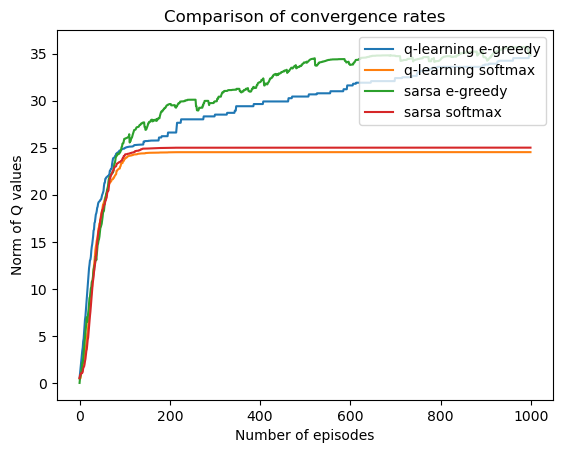

<Figure size 640x480 with 0 Axes>

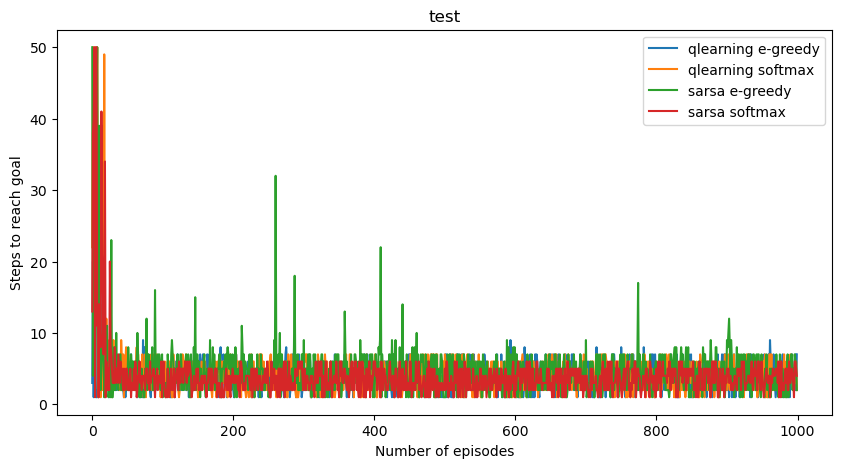

In [88]:
# example
beta = 0.5
epsilon = 0.02
plot_ql_sarsa(env, epsilon, beta, 1000, 100, 0.5, False)

### Effect of hyper-parameters

The other two hyper-parameters of **q-learning** and **sarsa** are $\alpha$,
and $\gamma$. By varying the values of these hyper-parameters and watching the
learning process and behavior of the agent, explain their impact on the
algorithm. Using additional plotting functions is also welcome.

A good idea to visualize the effect of two parameters is to generate a heat map
by letting both parameters take values in a well-chosen interval

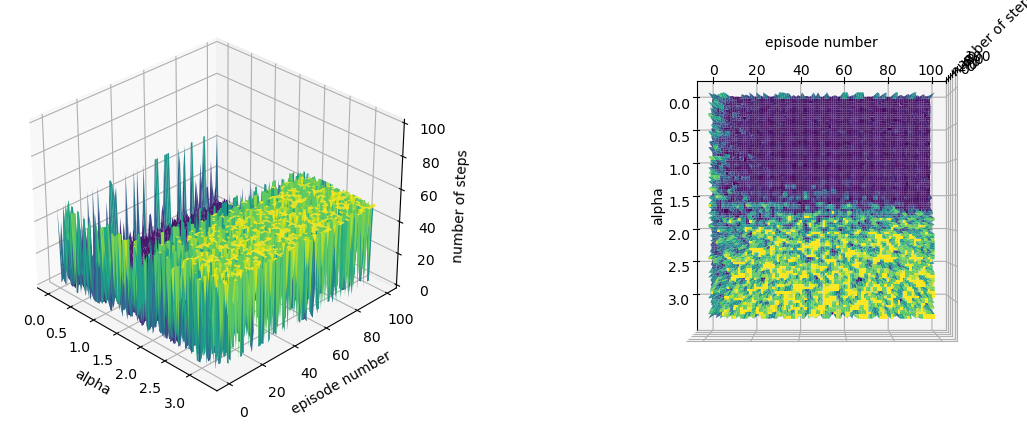

In [148]:
n = 100

alpha = np.zeros([n,1])
epis = np.arange(n)
K = np.zeros([n,n])

for i in range(n) :
    alpha[i] = i/30 
    _, _, K[i] = q_learning_eps(mdp = env, epsilon= 0.1, alpha = alpha[i], nb_episodes = n, render = False)

# Create the first 3D subplot with the first view angle
fig = plt.figure(figsize=[13,10])
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(alpha, epis, K, rstride=1, cstride=1, alpha=1, cmap='viridis', edgecolor='none')
ax1.set_xlabel('alpha')
ax1.set_ylabel('episode number')
ax1.set_zlabel('number of steps')
ax1.set_zlim(0, 100)
ax1.view_init(elev=30, azim=-45)

# Create the second 3D subplot with the second view angle
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(alpha, epis, K, rstride=1, cstride=1, alpha=1, cmap='viridis', edgecolor='none')
ax2.set_xlabel('alpha')
ax2.set_ylabel('episode number')
ax2.set_zlabel('number of steps')
ax2.set_zlim(0, 100)
ax2.view_init(elev=90, azim=0)

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.5)

# Display the plot
plt.show()


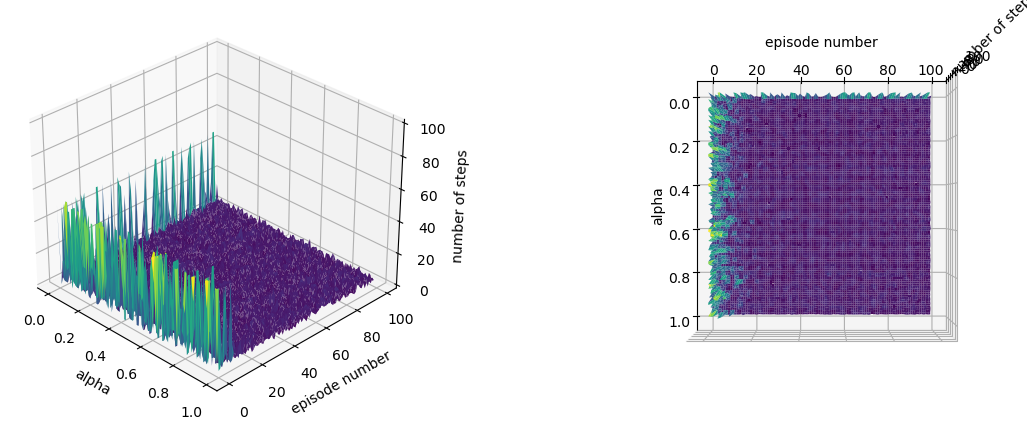

In [167]:
n = 100

gamma = np.zeros([n,1])
epis = np.arange(n)
K = np.zeros([n,n])

for i in range(n) :
    gamma[i] = i/n
    _, _, K[i] = q_learning_eps(mdp = env, epsilon= 0.02, gamma = gamma[i],timeout=100, nb_episodes = n, render = False)

# Create the first 3D subplot with the first view angle
fig = plt.figure(figsize=[13,10])
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(gamma, epis, K, rstride=1, cstride=1, alpha=1, cmap='viridis', edgecolor='none')
ax1.set_xlabel('alpha')
ax1.set_ylabel('episode number')
ax1.set_zlabel('number of steps')
ax1.set_zlim(0, 100)
ax1.view_init(elev=30, azim=-45)

# Create the second 3D subplot with the second view angle
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(gamma, epis, K, rstride=1, cstride=1, alpha=1, cmap='viridis', edgecolor='none')
ax2.set_xlabel('alpha')
ax2.set_ylabel('episode number')
ax2.set_zlabel('number of steps')
ax2.set_zlim(0, 100)
ax2.view_init(elev=90, azim=0)

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.5)

# Display the plot
plt.show()


# Investigation of the Impacts of α and γ

From a theoretical standpoint, we recognize that α, which governs the learning rate, determines the size of each step taken towards the optimal solution. A smaller learning rate implies slower convergence, leading to a higher number of episodes, each comprising numerous steps. As the learning rate increases, the number of steps required for convergence decreases, but only up to a certain threshold (approximately 0.75 in our case). Beyond this point, the algorithm begins to diverge, missing the optimal solution due to excessively high learning rates.

In the case of γ, the discount factor's effect is somewhat less straightforward. In this particular problem, there is only one state associated with a reward. Consequently, any γ value greater than 0 will facilitate algorithm convergence. When γ is set to 0, however, learning is nearly non-existent, resulting in a persistently high number of steps.

## Actor-critic approach

In this last part, we code the naive actor-critic approach with a categorical policy

In [31]:
def actor_critic_v(mdp: MazeMDPEnv,
                   nb_episodes: int, 
                   alpha_critic: float,
                   alpha_actor: float,
                   timeout: int,
                   render: bool = True,
                  ) -> float:

    v = np.zeros(mdp.nb_states)  # initial action values are set to 0
    policy = np.ones((mdp.nb_states, mdp.action_space.n)) / mdp.action_space.n # action probabilities are uniform

    mdp.timeout = timeout  # episode length

    video_recorder = VideoRecorder(mdp, "videos/Actor-Critic.mp4", enabled=render)
    mdp.init_draw("SaActor-Critic", recorder=video_recorder)

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=True)
        done = False

        while not done:

            u = sample_categorical(softmax(policy, x, 0.05)) 
            mdp.draw_v(v, recorder=video_recorder)
            
            # Perform a step of the MDP
            y, r, done, *_ = mdp.step(u)
            # print(x, y, r, done, (1 - done))

            # Update the value function 
            delta = r + 0.9 * v[y] - v[x]
            v[x] += alpha_critic * delta

            # Update the policy function 
            policy[x,u] += alpha_actor * delta

            # Update the agent position
            x = y

    mdp.draw_v(v, recorder=video_recorder)
    video_recorder.close()

    return np.linalg.norm(v)

Let us visualize the effect of the actor and critic alpha parameters

In [32]:
v_norm = actor_critic_v(env, NB_EPISODES, 0.1, 0.1, TIMEOUT)

Moviepy - Building video videos/Actor-Critic.mp4.
Moviepy - Writing video videos/Actor-Critic.mp4



Moviepy - Done !
Moviepy - video ready videos/Actor-Critic.mp4


In [81]:
video_display("videos/Actor-Critic.mp4")